In [2]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
import datetime

In [17]:
def variance(w, cov):
    return np.dot(w.T, np.dot(cov,w))

def returns(w, exp):
    return np.dot(w.T, exp)

In [18]:
DATA_PATH = '../data'
PRICES_PATH = os.path.join(DATA_PATH, 'prices')
SIMULATION_DATA_PATH = os.path.join(DATA_PATH, 'simulation data')
prices = pd.read_csv(os.path.join(PRICES_PATH, 'Spain_prices.csv'))

In [19]:
prices['price'] = prices['Price (EUR/MWhe)']
prices['time'] = pd.to_datetime(prices['Datetime (UTC)'])


In [20]:
prices['hour'] = prices['time'].dt.hour
prices['day'] = prices['time'].dt.day
prices['month'] = prices['time'].dt.month
prices['year'] = prices['time'].dt.year
prices.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe),price,time,hour,day,month,year
0,Spain,ESP,2015-01-01 00:00:00,2015-01-01 01:00:00,48.10,48.10,2015-01-01 00:00:00,0,1,1,2015
1,Spain,ESP,2015-01-01 01:00:00,2015-01-01 02:00:00,47.33,47.33,2015-01-01 01:00:00,1,1,1,2015
2,Spain,ESP,2015-01-01 02:00:00,2015-01-01 03:00:00,42.27,42.27,2015-01-01 02:00:00,2,1,1,2015
3,Spain,ESP,2015-01-01 03:00:00,2015-01-01 04:00:00,38.41,38.41,2015-01-01 03:00:00,3,1,1,2015
4,Spain,ESP,2015-01-01 04:00:00,2015-01-01 05:00:00,35.72,35.72,2015-01-01 04:00:00,4,1,1,2015


In [23]:
df_list = []
for file_name in os.listdir(SIMULATION_DATA_PATH):
    df = pd.read_csv(os.path.join(SIMULATION_DATA_PATH, file_name),sep = ',', comment = '#')
    file_name_split = file_name.split('_')
    df['lat_lon'] = file_name_split[2]+ '_' + file_name_split[3]
    df_list.append(df)
production = pd.concat(df_list)

In [24]:
production['time'] = pd.to_datetime(production['time'])
production['hour'] = production['time'].dt.hour
production['day'] = production['time'].dt.day
production['month'] = production['time'].dt.month
production['year'] = production['time'].dt.year
# production_hours_count = production.groupby(['lat_lon', 'year', 'month', 'day', 'hour']).size().reset_index(name='count')

production.head()

,time,local_time,electricity,lat_lon,hour,day,month,year
0,2019-01-01 00:00:00,2019-01-01 01:00,0.251,37.3467_-5.6815,0,1,1,2019
1,2019-01-01 01:00:00,2019-01-01 02:00,0.259,37.3467_-5.6815,1,1,1,2019
2,2019-01-01 02:00:00,2019-01-01 03:00,0.261,37.3467_-5.6815,2,1,1,2019
3,2019-01-01 03:00:00,2019-01-01 04:00,0.248,37.3467_-5.6815,3,1,1,2019
4,2019-01-01 04:00:00,2019-01-01 05:00,0.243,37.3467_-5.6815,4,1,1,2019


In [25]:
final_time_price = prices['time'].max() #- pd.Timedelta(days=1) + pd.Timedelta(hours=1)
start_time_price = final_time_price - pd.Timedelta(days=365)

In [26]:
mask_dates = (prices['time'] <= final_time_price) & (prices['time'] > start_time_price)
last_y_prices = prices[mask_dates]

In [27]:
last_y_prices.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe),price,time,hour,day,month,year
83469,Spain,ESP,2024-07-09 21:00:00,2024-07-09 23:00:00,116.38,116.38,2024-07-09 21:00:00,21,9,7,2024
83470,Spain,ESP,2024-07-09 22:00:00,2024-07-10 00:00:00,107.94,107.94,2024-07-09 22:00:00,22,9,7,2024
83471,Spain,ESP,2024-07-09 23:00:00,2024-07-10 01:00:00,106.81,106.81,2024-07-09 23:00:00,23,9,7,2024
83472,Spain,ESP,2024-07-10 00:00:00,2024-07-10 02:00:00,104.22,104.22,2024-07-10 00:00:00,0,10,7,2024
83473,Spain,ESP,2024-07-10 01:00:00,2024-07-10 03:00:00,102.61,102.61,2024-07-10 01:00:00,1,10,7,2024


In [33]:
production.head()

,time,local_time,electricity,lat_lon,hour,day,month,year
0,2019-01-01 00:00:00,2019-01-01 01:00,0.251,37.3467_-5.6815,0,1,1,2019
1,2019-01-01 01:00:00,2019-01-01 02:00,0.259,37.3467_-5.6815,1,1,1,2019
2,2019-01-01 02:00:00,2019-01-01 03:00,0.261,37.3467_-5.6815,2,1,1,2019
3,2019-01-01 03:00:00,2019-01-01 04:00,0.248,37.3467_-5.6815,3,1,1,2019
4,2019-01-01 04:00:00,2019-01-01 05:00,0.243,37.3467_-5.6815,4,1,1,2019


In [28]:
df_revenue = pd.merge(production, last_y_prices, on=['hour','day','month'], how='inner')
df_revenue = df_revenue[['lat_lon','price','electricity','hour','day','month']]

In [31]:
# compute asset revenue
df_revenue['revenue'] = (df_revenue['price'] * df_revenue['electricity']).round(3)
df_revenue['year'] = 2019
df_revenue['time_stamp'] = df_revenue[['year', 'month', 'day', 'hour']].apply(lambda s : datetime.datetime(*s),axis = 1)

In [37]:
monthly_rev = pd.pivot_table(df_revenue, values='revenue', index='time_stamp', columns='lat_lon', aggfunc='sum')

monthly_rev

lat_lon,37.3467_-5.6815,37.5021_-4.4298,37.6571_-2.4870,38.3250_-3.2432,38.4885_-5.0687,38.5089_-1.1831,38.7432_-6.7377,40.2523_-1.9654,40.3220_-0.1269,40.3617_-4.5602,40.5403_-6.2422,41.3479_1.0205,41.5629_-5.7467,41.5727_-1.7437,41.5824_-3.7648,41.6591_0.8423,42.4587_-8.3965,42.9692_-1.9821,43.0932_-4.2335,43.1742_-6.5667
time_stamp,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,33.029,19.870,0.395,12.764,13.159,69.611,24.081,18.817,36.582,2.237,2.632,29.871,26.844,76.585,10.922,20.396,21.712,8.159,1.053,51.320
2019-01-01 01:00:00,34.056,19.724,0.394,12.492,13.543,75.081,23.668,16.305,24.063,3.024,2.761,27.613,31.426,78.237,10.388,16.305,21.959,10.519,0.657,49.046
2019-01-01 02:00:00,34.301,17.873,0.526,11.434,12.616,77.538,21.684,15.508,17.216,4.337,3.023,28.518,35.746,81.218,10.251,16.033,21.027,13.536,1.051,46.391
2019-01-01 03:00:00,29.882,12.169,0.964,7.952,8.193,74.463,14.700,15.182,12.410,5.302,3.012,26.990,33.978,77.114,9.880,15.061,16.748,14.097,1.566,38.918
2019-01-01 04:00:00,27.289,7.524,2.246,4.941,4.380,73.444,8.759,16.396,12.353,6.064,3.032,24.369,31.219,73.893,10.107,14.038,13.139,12.578,2.246,31.556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,22.634,7.805,3.122,0.780,0.780,5.464,9.834,2.810,6.400,0.468,0.624,11.083,11.239,2.966,0.937,8.117,39.649,2.342,0.468,3.902
2019-12-31 20:00:00,24.287,9.956,2.564,0.905,1.056,5.280,9.051,3.319,8.146,1.056,1.207,10.710,10.710,9.051,1.056,6.788,37.411,1.056,0.603,5.581
2019-12-31 21:00:00,24.115,12.707,2.888,2.022,1.444,5.920,8.375,5.487,8.953,1.733,2.022,10.397,9.097,13.862,1.588,5.198,33.645,0.578,2.310,8.520


In [33]:
cov = monthly_rev.cov()
exp = monthly_rev.sum()

In [35]:
# Hourly correlation is still very big although some points close to 0.5 
rev_corr_matrix = monthly_rev.corr()

In [17]:
monthly_rev.corr()

lat_lon,37.3467_-5.6815,37.5021_-4.4298,37.6571_-2.4870,38.3250_-3.2432,38.4885_-5.0687,38.5089_-1.1831,38.7432_-6.7377,40.2523_-1.9654,40.3220_-0.1269,40.3617_-4.5602,40.5403_-6.2422,41.3479_1.0205,41.5629_-5.7467,41.5727_-1.7437,41.5824_-3.7648,41.6591_0.8423,42.4587_-8.3965,42.9692_-1.9821,43.0932_-4.2335,43.1742_-6.5667
lat_lon,,,,,,,,,,,,,,,,,,,,
37.3467_-5.6815,1.000000,0.911575,0.677568,0.821089,0.872751,0.597181,0.858806,0.702995,0.549168,0.762972,0.704127,0.544645,0.677923,0.630472,0.689946,0.551101,0.597882,0.607766,0.611486,0.587454
37.5021_-4.4298,0.911575,1.000000,0.722266,0.868972,0.872836,0.590960,0.818252,0.721791,0.541304,0.769579,0.692802,0.552731,0.668060,0.612945,0.696257,0.568978,0.568050,0.586779,0.600938,0.565304
37.6571_-2.4870,0.677568,0.722266,1.000000,0.794141,0.742312,0.867996,0.687648,0.790000,0.717770,0.761707,0.650148,0.701093,0.666725,0.715434,0.711083,0.672782,0.552724,0.616414,0.673416,0.635042
38.3250_-3.2432,0.821089,0.868972,0.794141,1.000000,0.879412,0.639370,0.805384,0.769734,0.561245,0.817785,0.708104,0.553838,0.703365,0.639416,0.754345,0.563856,0.589063,0.603653,0.606588,0.606398
38.4885_-5.0687,0.872751,0.872836,0.742312,0.879412,1.000000,0.632993,0.910957,0.785274,0.604089,0.856686,0.785806,0.581414,0.763866,0.679083,0.777851,0.586352,0.618096,0.632199,0.649852,0.627257
38.5089_-1.1831,0.597181,0.590960,0.867996,0.639370,0.632993,1.000000,0.609225,0.759989,0.790488,0.677653,0.604717,0.741168,0.613072,0.731718,0.637688,0.692436,0.552369,0.591121,0.649159,0.621148
38.7432_-6.7377,0.858806,0.818252,0.687648,0.805384,0.910957,0.609225,1.000000,0.743556,0.567522,0.838801,0.827790,0.561168,0.797501,0.684324,0.782880,0.565091,0.661971,0.647093,0.675734,0.649000
40.2523_-1.9654,0.702995,0.721791,0.790000,0.769734,0.785274,0.759989,0.743556,1.000000,0.793686,0.873493,0.784616,0.755265,0.773994,0.836356,0.845679,0.766696,0.650067,0.731566,0.702839,0.675584
40.3220_-0.1269,0.549168,0.541304,0.717770,0.561245,0.604089,0.790488,0.567522,0.793686,1.000000,0.689234,0.631533,0.787013,0.565747,0.768045,0.601442,0.754284,0.494974,0.597510,0.589121,0.535861


In [40]:
# Random weights
n_samples = 1000
n_locations = monthly_rev.shape[1]

w_np = np.random.uniform(size=(n_samples, n_locations))
w_np /= w_np.sum(axis=1, keepdims=True)
df_w = pd.DataFrame(w_np, columns=monthly_rev.columns)
df_w

lat_lon,37.3467_-5.6815,37.5021_-4.4298,37.6571_-2.4870,38.3250_-3.2432,38.4885_-5.0687,38.5089_-1.1831,38.7432_-6.7377,40.2523_-1.9654,40.3220_-0.1269,40.3617_-4.5602,40.5403_-6.2422,41.3479_1.0205,41.5629_-5.7467,41.5727_-1.7437,41.5824_-3.7648,41.6591_0.8423,42.4587_-8.3965,42.9692_-1.9821,43.0932_-4.2335,43.1742_-6.5667
0,0.065581,0.027343,0.070363,0.018535,0.084732,0.087581,0.010182,0.048692,0.075534,0.042782,0.020999,0.025078,0.025095,0.070411,0.039582,0.058904,0.023962,0.059364,0.073840,0.071441
1,0.056077,0.029760,0.035315,0.068058,0.065350,0.028753,0.057616,0.062232,0.055414,0.014894,0.037264,0.074960,0.082079,0.059058,0.007571,0.053706,0.063943,0.072578,0.041687,0.033686
2,0.034403,0.021523,0.047464,0.007814,0.056725,0.026110,0.099402,0.068911,0.093962,0.103508,0.065634,0.090187,0.069201,0.004315,0.009434,0.022581,0.033839,0.030791,0.016099,0.098097
3,0.068363,0.061442,0.070461,0.049843,0.032314,0.083208,0.033718,0.033573,0.027156,0.020699,0.050054,0.040634,0.029687,0.049582,0.052611,0.049526,0.076670,0.097431,0.023017,0.050011
4,0.004598,0.062956,0.057904,0.062797,0.043650,0.064263,0.068829,0.066785,0.070832,0.004885,0.068417,0.069197,0.060301,0.068736,0.044262,0.027167,0.021245,0.048794,0.049717,0.034665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.072703,0.084109,0.032532,0.068649,0.022964,0.063388,0.077570,0.021107,0.066630,0.009740,0.078344,0.032579,0.018189,0.050118,0.058192,0.051115,0.076185,0.071030,0.013429,0.031428
996,0.080772,0.084541,0.014386,0.074796,0.035663,0.039509,0.074736,0.011047,0.026405,0.041076,0.006076,0.046838,0.002816,0.049003,0.055250,0.086917,0.079285,0.067868,0.034285,0.088732
997,0.049963,0.054124,0.059594,0.064715,0.041766,0.032181,0.048836,0.070235,0.060979,0.027619,0.076034,0.077219,0.028819,0.074578,0.031469,0.037569,0.026898,0.020146,0.045463,0.071794
998,0.029717,0.062173,0.029231,0.015716,0.038768,0.033790,0.001914,0.038318,0.035090,0.079814,0.016251,0.094490,0.096295,0.062997,0.055139,0.080607,0.042695,0.014966,0.107949,0.064081


In [19]:
df_plot = pd.DataFrame(data = [], index=df_w.index)
df_plot['cov'] =  df_w.apply(variance, axis=1, cov=cov)
df_plot['exp'] = df_w.apply(returns, axis=1, exp=exp)

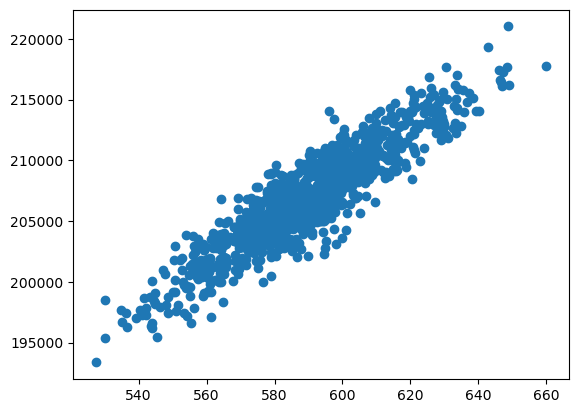

In [20]:
plt.scatter(x=df_plot['cov'], y=df_plot['exp'])
plt.show()

In [21]:
ef = EfficientFrontier(exp, cov, weight_bounds=(0,1))
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)


OrderedDict([('37.3467_-5.6815', 0.0), ('37.5021_-4.4298', 0.44462), ('37.6571_-2.4870', 0.0), ('38.3250_-3.2432', 0.0), ('38.4885_-5.0687', 0.0), ('38.5089_-1.1831', 0.0), ('38.7432_-6.7377', 0.0), ('40.2523_-1.9654', 0.0), ('40.3220_-0.1269', 0.0), ('40.3617_-4.5602', 0.0), ('40.5403_-6.2422', 0.0), ('41.3479_1.0205', 0.0), ('41.5629_-5.7467', 0.0), ('41.5727_-1.7437', 0.0), ('41.5824_-3.7648', 0.0), ('41.6591_0.8423', 0.24073), ('42.4587_-8.3965', 0.25994), ('42.9692_-1.9821', 0.05471), ('43.0932_-4.2335', 0.0), ('43.1742_-6.5667', 0.0)])
Expected annual return: 16450057.3%
Annual volatility: 2013.0%
Sharpe Ratio: 8171.81


(164500.57272483036, 20.130242848832836, 8171.812628398977)

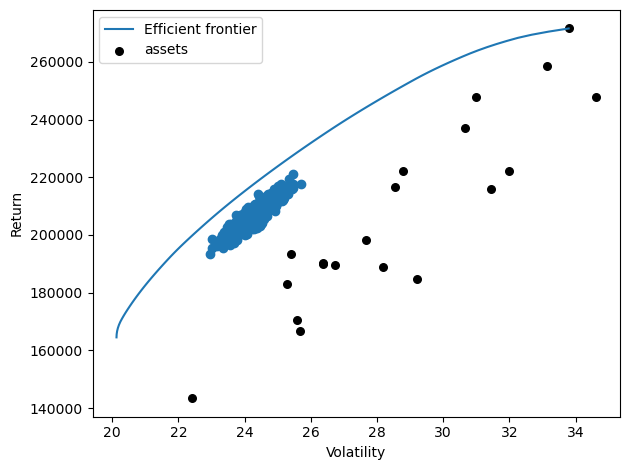

In [ ]:
# Now we get more resonable picture TODO: see which linear convinations we get the blue curve.
ef = EfficientFrontier(exp, cov,  weight_bounds=(0,1))
fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.scatter(x=np.sqrt(df_plot['cov']), y=df_plot['exp'])
plt.show()

In [ ]:
# LOOK CORRELATIONS AND SEE IF COMBINATION CAN LOWER VOLATITLITY


<Axes: xlabel='Volatility', ylabel='Return'>

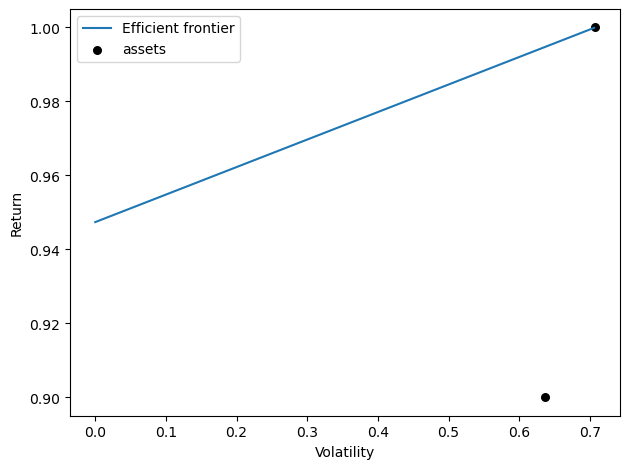

In [24]:
aux = pd.DataFrame({'A':[1,0],'B':[0,0.90]})
cov = aux.cov()
exp = aux.sum()

ef = EfficientFrontier(exp,cov,  weight_bounds=(0,1))
fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)


In [ ]:
# TODO: utilitzar els 10 anys de preus?

In [45]:
hourly_returns = monthly_rev.pct_change().dropna()

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, plotting

In [49]:
# Assuming `hourly_returns` is a DataFrame with hourly returns for 20 assets
hourly_returns = hourly_returns.replace([np.inf, -np.inf], 0)


cov_matrix = hourly_returns.cov()
expected_returns = hourly_returns.mean()

In [50]:
# Check for infinite values
print("Infinite values before cleaning:")
print(f"Number of inf values: {np.isinf(hourly_returns).sum().sum()}")
print(f"Number of -inf values: {np.isneginf(hourly_returns).sum().sum()}")


Infinite values before cleaning:
Number of inf values: 0
Number of -inf values: 0


In [73]:

# Generate random portfolios
n_samples = 10000
n_assets = hourly_returns.shape[1]
weights = np.random.uniform(low=0, high=2, size=(n_samples, n_assets))
# weights /= weights.sum(axis=1, keepdims=True)


In [74]:
sample_capacity = np.sum(weights, axis=1)

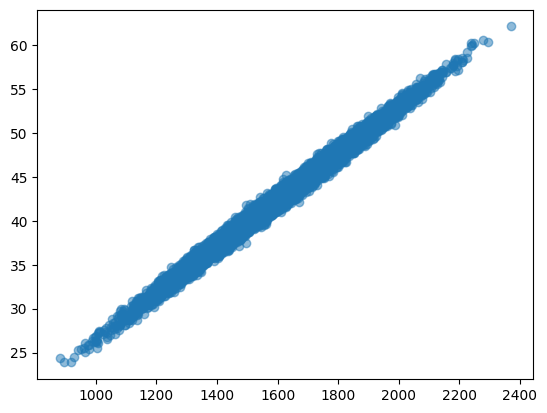

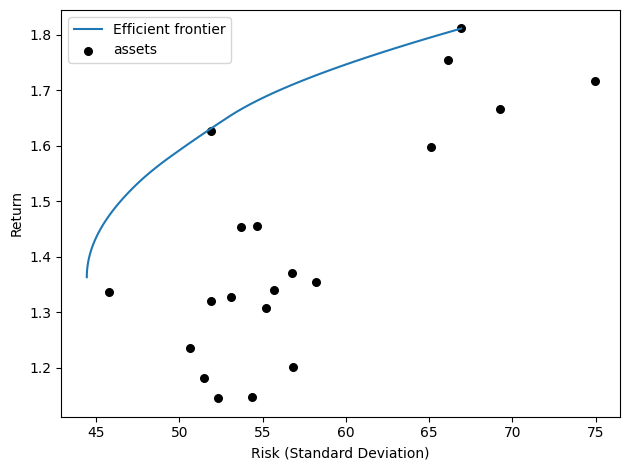

In [67]:

# Calculate portfolio risk and return
portfolio_returns = np.dot(weights, expected_returns)
portfolio_risks = np.sqrt(np.einsum('ij,jk,ik->i', weights, cov_matrix, weights))

# Plot random portfolios
plt.scatter(portfolio_risks, portfolio_returns, alpha=0.5, label="Random Portfolios")

# Optimize using pypfopt
ef = EfficientFrontier(expected_returns, cov_matrix)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

plt.xlabel("Risk (Standard Deviation)")
plt.ylabel("Return")
plt.legend()
plt.show()

In [68]:
# Minimum Variance Portfolio
ef_min_var = EfficientFrontier(expected_returns, cov_matrix, weight_bounds=(0, 1))
weights_min_var = ef_min_var.min_volatility()
cleaned_weights_min_var = ef_min_var.clean_weights()
print("Minimum Variance Portfolio Weights:")
print(cleaned_weights_min_var)
ef_min_var.portfolio_performance(verbose=True)

# Maximum Sharpe Ratio Portfolio
ef_max_sharpe = EfficientFrontier(expected_returns, cov_matrix, weight_bounds=(0, 1))
weights_max_sharpe = ef_max_sharpe.max_sharpe()
cleaned_weights_max_sharpe = ef_max_sharpe.clean_weights()
print("\nMaximum Sharpe Ratio Portfolio Weights:")
print(cleaned_weights_max_sharpe)
ef_max_sharpe.portfolio_performance(verbose=True)

Minimum Variance Portfolio Weights:
OrderedDict({'37.3467_-5.6815': 0.0, '37.5021_-4.4298': 0.0, '37.6571_-2.4870': 0.0, '38.3250_-3.2432': 0.0, '38.4885_-5.0687': 0.0, '38.5089_-1.1831': 0.177, '38.7432_-6.7377': 0.0, '40.2523_-1.9654': 0.0, '40.3220_-0.1269': 0.63707, '40.3617_-4.5602': 0.0, '40.5403_-6.2422': 0.0, '41.3479_1.0205': 0.0, '41.5629_-5.7467': 0.0, '41.5727_-1.7437': 0.0, '41.5824_-3.7648': 0.0, '41.6591_0.8423': 0.0, '42.4587_-8.3965': 0.0, '42.9692_-1.9821': 0.0, '43.0932_-4.2335': 0.18593, '43.1742_-6.5667': 0.0})
Expected annual return: 136.3%
Annual volatility: 4443.5%
Sharpe Ratio: 0.03

Maximum Sharpe Ratio Portfolio Weights:
OrderedDict({'37.3467_-5.6815': 0.0, '37.5021_-4.4298': 0.0, '37.6571_-2.4870': 0.0, '38.3250_-3.2432': 0.0, '38.4885_-5.0687': 0.0, '38.5089_-1.1831': 0.60712, '38.7432_-6.7377': 0.0, '40.2523_-1.9654': 0.0, '40.3220_-0.1269': 0.37216, '40.3617_-4.5602': 0.0, '40.5403_-6.2422': 0.0, '41.3479_1.0205': 0.0, '41.5629_-5.7467': 0.0, '41.5727_-1.

(np.float64(1.5102813521078784),
 np.float64(46.77430699987492),
 np.float64(0.03228869541801906))

In [62]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame with longitude and latitude
data = {
    'latitude': [40.4168, 41.3879, 39.4699],
    'longitude': [-3.7038, 2.1699, -0.3763],
    'location': ['Madrid', 'Barcelona', 'Valencia']
}
df = pd.DataFrame(data)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['longitude'], df['latitude'])
)

# Plot the points on a map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6), color='lightgray', edgecolor='black')
gdf.plot(ax=ax, color='red', markersize=50)

# Add labels
for x, y, label in zip(df['longitude'], df['latitude'], df['location']):
    plt.text(x, y, label, fontsize=8, ha='right')

plt.show()

AttributeError: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.